<a href="https://colab.research.google.com/github/dksifoua/Neural-Machine-Translation/blob/master/NMT_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchtext --upgrade
!python -m spacy download fr
!python -m spacy download en

Requirement already up-to-date: torchtext in /usr/local/lib/python3.6/dist-packages (0.5.0)
✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/fr_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/fr
You can now load the model via spacy.load('fr')
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [0]:

import os
import re
import tqdm
import random
import unicodedata
import numpy as np
import matplotlib.pyplot as plt

import spacy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext.data import Example, Field, Dataset
from torchtext.data.iterator import BucketIterator

%matplotlib inline

In [0]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

SEED = 781
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
if not os.path.exists('./data'):
    !mkdir ./data

!wget --no-check-certificate \
    http://www.statmt.org/europarl/v7/fr-en.tgz \
    -O ./data/fr-en.tgz

--2020-02-17 06:03:10--  http://www.statmt.org/europarl/v7/fr-en.tgz
Resolving www.statmt.org (www.statmt.org)... 129.215.197.184
Connecting to www.statmt.org (www.statmt.org)|129.215.197.184|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 202718517 (193M) [application/x-gzip]
Saving to: ‘./data/fr-en.tgz’

./data/fr-en.tgz    100%[===================>] 193.33M  1.57MB/s    in 2m 3s   

2020-02-17 06:05:13 (1.57 MB/s) - ‘./data/fr-en.tgz’ saved [202718517/202718517]



In [5]:
!tar -xzvf ./data/fr-en.tgz -C ./data/

europarl-v7.fr-en.en
europarl-v7.fr-en.fr


In [0]:
def read_file(filepath):
    try:
        with open(filepath, mode='rt', encoding='utf-8') as file:
            content = file.readlines()
        return content
    except:
        raise NotImplementedError(f'File {filepath} doesn\'t exist')

In [0]:
def unicode_to_ascii(s):
    # NFD => Normal Form Decompose
    # Mn => Non Marking Space
    return ''.join(c for c in unicodedata.normalize('NFD', s) \
                    if unicodedata.category(c) != 'Mn')

def normalize_string(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r'([!.?])', r' \1', s)
    s = re.sub(r'[^a-zA-Z1-9!.?]+', r' ', s)
    s = re.sub(r'\s+', r' ', s)
    return s.strip()

In [8]:
%%time
pairs = [*zip(read_file('./data/europarl-v7.fr-en.fr'),
             read_file('./data/europarl-v7.fr-en.en'))]
pairs = [*map(lambda x: {'fr': x[0], 'en': x[1]}, pairs)]
print('Number of examples:', len(pairs))
pairs = np.random.choice(pairs, size=30000, replace=False)
pairs = [*map(lambda pair: {k: normalize_string(v) for k, v in pair.items()},
              pairs)]
print('Number of examples after sampling:', len(pairs))
print('Example:', pairs[0])

Number of examples: 2007723
Number of examples after sampling: 30000
Example: {'fr': 'les procedures par le biais desquelles de tels produits entrent et sortent de l union europeenne doivent etre ouvertes transparentes et par dessus tout sures .', 'en': 'the procedures whereby such products come in and out of the european union have to be open transparent and above all safe .'}
CPU times: user 6.98 s, sys: 921 ms, total: 7.9 s
Wall time: 7.91 s


In [9]:
%%time
FR = Field(init_token='<sos>',
           eos_token='<eos>',
           pad_token='<pad>',
           unk_token='<unk>',
           lower=True,
           tokenize='spacy',
           tokenizer_language='fr',
           preprocessing=lambda x: x[::-1])
EN = Field(init_token='<sos>',
           eos_token='<eos>',
           pad_token='<pad>',
           unk_token='<unk>',
           lower=True,
           tokenize='spacy',
           tokenizer_language='en')

examples = [Example.fromdict(data=pair, fields={'fr': ('src', FR),
                                                'en': ('dest', EN)})
            for pair in tqdm.tqdm(pairs)]
data = Dataset(examples, fields={'src': FR, 'dest': EN})
train_data, valid_data, test_data = data.split(split_ratio=[0.7, 0.2, 0.1])
print('train size:', len(train_data.examples))
print('valid size:', len(valid_data.examples))
print('test size:', len(test_data.examples))
print(vars(train_data.examples[0]))

100%|██████████| 30000/30000 [00:46<00:00, 647.90it/s]


train size: 21000
valid size: 3000
test size: 6000
{'src': ['.', 'europeenne', 'communaute', 'la', 'de', 'niveau', 'au', 'gestion', 'micro', 'une', 'a', 'proceder', 'de', 'tentation', 'la', 'a', 'resister', 'de', 'que', 'ainsi', 'terrain', 'de', 'acteurs', 'les', 'par', 'fournies', 'etre', 'peuvent', 'qui', 'competences', 'des', 'et', 'connaissances', 'des', 'ampleur', 'l', 'reconnaitre', 'de', 'important', 'est', 'il', 'et', 'propre', 'specificite', 'sa', 'possede', 'europeennes', 'mers', 'des', 'chacune'], 'dest': ['each', 'of', 'the', 'seas', 'in', 'europe', 'has', 'its', 'own', 'specificity', 'and', 'it', 'is', 'important', 'to', 'recognise', 'the', 'level', 'of', 'knowledge', 'and', 'expertise', 'that', 'can', 'be', 'provided', 'by', 'the', 'stakeholders', 'on', 'the', 'ground', 'and', 'to', 'resist', 'the', 'temptation', 'to', 'micro', 'manage', 'on', 'an', 'eu', 'level', '.']}
CPU times: user 50 s, sys: 444 ms, total: 50.5 s
Wall time: 50.5 s


In [0]:
FR.build_vocab(train_data, min_freq=5,
               specials=['<sos>', '<eos>', '<unk>', '<pad>'])
EN.build_vocab(train_data, min_freq=5,
               specials=['<sos>', '<eos>', '<unk>', '<pad>'])

In [11]:
print('Length of FR vocabulary:', len(FR.vocab))
print('Length of EN vocabulary:', len(EN.vocab))

Length of FR vocabulary: 6819
Length of EN vocabulary: 5822


In [0]:
class Encoder(nn.Module):

    def __init__(self, vocab_size, embedding_dim,
                 hidden_units, n_layers, dropout, bi=True):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=hidden_units,
                            num_layers=n_layers,
                            bidirectional=bi,
                            dropout=dropout)

    def forward(self, inputs):
        embedded = self.embedding(inputs)
        embedded = self.dropout(embedded)
        outputs, (h_state, c_state) = self.lstm(embedded)
        d, _, _ = h_state.size()
        h_state = h_state[:d//2, :, :] + h_state[d//2:, :, :]
        c_state = c_state[:d//2, :, :] + c_state[d//2:, :, :]
        return outputs, (h_state, c_state)

In [0]:
class Decoder(nn.Module):

    def __init__(self, vocab_size, embedding_dim,
                 hidden_units, n_layers, dropout):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=hidden_units,
                            num_layers=n_layers,
                            dropout=dropout)
        self.linear = nn.Linear(hidden_units, vocab_size)

    def forward(self, inputs, h_state, c_state):
        embedded = self.embedding(inputs)
        embedded = self.dropout(embedded)
        outputs, (h_state, c_state) = self.lstm(embedded, (h_state, c_state))
        logits = self.linear(outputs.squeeze(0))
        return logits, (h_state, c_state)

In [0]:
class SeqToSeqNet(nn.Module):

    def __init__(self, encoder, decoder):
        super(SeqToSeqNet, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, inputs, target_len, eos_index=None):
        enc_out, (h_state, c_state) = self.encoder(inputs)
        in_dec = inputs[0, :].unsqueeze(0)
        logits = []
        for t in range(1, target_len):
            logit, (h_state, c_state) = self.decoder(in_dec, h_state, c_state)
            logits.append(logit)
            in_dec = logit.argmax(1).unsqueeze(0)
            if eos_index and in_dec[0][0] == eos_index:
                break
        return torch.stack(logits, dim=0)

In [0]:
# model = SeqToSeqNet(encoder, decoder)
# model.to(DEVICE)
# for i, data in enumerate(train_iterator):
#     logits = model(data.src, data.dest.shape[0])
#     print('dest shape', data.dest[1:, :].shape)
#     print('logits shape:', logits.shape)
#     d = logits.size(-1)
#     loss = criterion(logits.view(-1, d), data.dest[1:, :].view(-1))
#     print(loss.item())
#     break

In [0]:
def init_weights(model: nn.Module):
    for name, param in model.named_parameters():
        nn.init.uniform_(param.data, a=-0.08, b=0.08)

def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [0]:
def plot_grad_flow(named_parameters):
    grad_mean, layers = [], []
    for name, param in named_parameters:
        if param.requires_grad and 'bias' not in name:
            layers.append(name)
            grad_mean.append(param.grad.abs().mean())
    plt.plot(grad_mean, alpha=0.3, color='b')
    plt.hlines(0, 0, len(grad_mean) + 1, linewidth=1, color='k' )
    plt.xticks(range(0, len(grad_mean), 1), layers, rotation='vertical')
    plt.xlim(xmin=0, xmax=len(grad_mean))
    # plt.ylim(bottom=-0.001, top=0.02) # Zoom on lower gradients
    plt.xlabel('Layers')
    plt.ylabel('Mean of gradients')
    plt.title('Gradient Flow')
    plt.grid(True)

def train_step(model, opt, loss_func, data_it, grad_clip, epoch_text=''):
    epoch_loss = 0.
    pbar = tqdm.tqdm_notebook(enumerate(data_it), total=len(data_it))
    model.train()
    for i, data in pbar:
        opt.zero_grad()
        logits = model(data.src, data.dest.shape[0])
        d = logits.size(-1)
        loss = loss_func(logits.view(-1, d), data.dest[1:, :].view(-1))
        loss.backward()
        plot_grad_flow(model.named_parameters())
        if grad_clip:
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        opt.step()
        epoch_loss += loss.item()
        pbar.set_description(epoch_text + f'Train Loss: {epoch_loss/(i+1):.3f}')
    plt.show() # Show the gradient flow
    return epoch_loss / len(data_it)

def evaluate(model, loss_func, data_it):
    epoch_loss = 0.
    pbar = tqdm.tqdm_notebook(enumerate(data_it), total=len(data_it))
    model.eval()
    with torch.no_grad():
        for i, data in pbar:
            logits = model(data.src, data.dest.shape[0])
            d = logits.size(-1)
            loss = loss_func(logits.view(-1, d), data.dest[1:, :].view(-1))
            epoch_loss += loss.item()
            pbar.set_description(f'Valid Loss: {epoch_loss / (i + 1):.3f}')
    return epoch_loss / len(data_it)

def train(model, optimizer, loss_function, train_it, valid_it, n_epochs,
          grad_clip=None, save_to='./saved_models', filename='seq2seq.pt'):
    assert callable(loss_function)
    if not os.path.exists(save_to):
        !mkdir {save_to}

    history = {'loss': [], 'val_loss': []}
    best_loss = float('inf')
    for epoch in range(n_epochs):
        epoch_text = f'Epoch: {epoch + 1:02d} - '
        loss = train_step(model, optimizer, loss_function,
                          train_it, grad_clip, epoch_text)
        val_loss = evaluate(model, loss_function, valid_it)

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save({'model': model.state_dict(),
                        'optimizer': optimizer.state_dict()},
                       f=os.path.join(save_to, filename))

        history['loss'].append(loss)
        history['val_loss'].append(val_loss)

    return history

In [60]:
VOCAB_SIZE_FR = len(FR.vocab)
VOCAB_SIZE_EN = len(EN.vocab)
EMBEDDING_DIM_FR = 300
EMBEDDING_DIM_EN = 300
HIDDEN_UNITS_FR = 256
HIDDEN_UNITS_EN = 256
N_LAYERS_FR = 2
N_LAYERS_EN = 2
DROPOUT_FR = 0.25
DROPOUT_EN = 0.25
LR = 1e-3
GRAD_CLIP = 1.0
BATCH_SIZE = 128
N_EPOCHS = 20

encoder = Encoder(vocab_size=VOCAB_SIZE_FR,
                  embedding_dim=EMBEDDING_DIM_FR,
                  hidden_units=HIDDEN_UNITS_FR,
                  n_layers=N_LAYERS_FR,
                  dropout=DROPOUT_FR)
decoder = Decoder(vocab_size=VOCAB_SIZE_EN,
                  embedding_dim=EMBEDDING_DIM_EN,
                  hidden_units=HIDDEN_UNITS_EN,
                  n_layers=N_LAYERS_EN,
                  dropout=DROPOUT_EN)
model = SeqToSeqNet(encoder, decoder)
model.to(DEVICE)
model.apply(init_weights)
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss(ignore_index=EN.vocab.stoi[EN.pad_token])

print(model)
print('Number of parameters of the model:', count_parameters(model))

SeqToSeqNet(
  (encoder): Encoder(
    (embedding): Embedding(6819, 300)
    (dropout): Dropout(p=0.25, inplace=False)
    (lstm): LSTM(300, 256, num_layers=2, dropout=0.25, bidirectional=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(5822, 300)
    (dropout): Dropout(p=0.25, inplace=False)
    (lstm): LSTM(300, 256, num_layers=2, dropout=0.25)
    (linear): Linear(in_features=256, out_features=5822, bias=True)
  )
)
Number of parameters of the model: 9106026


In [0]:
train_iterator, valid_iterator, test_iterator =  \
        BucketIterator.splits((train_data, valid_data,
                               test_data),
                              batch_size=BATCH_SIZE,
                              sort_key=lambda x: (len(x.src), len(x.dest)),
                              device=DEVICE)

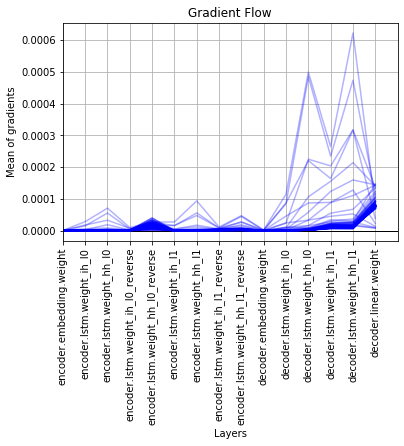

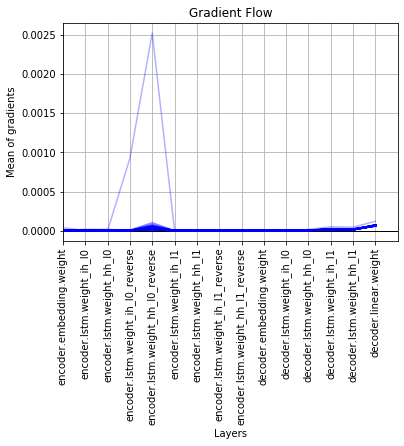

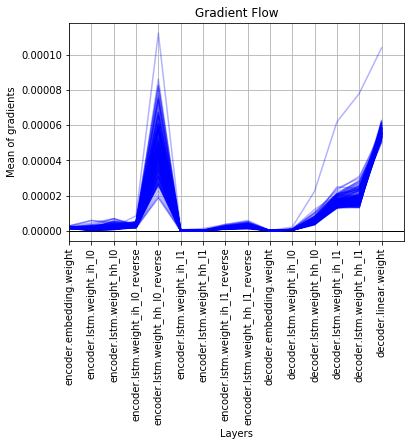

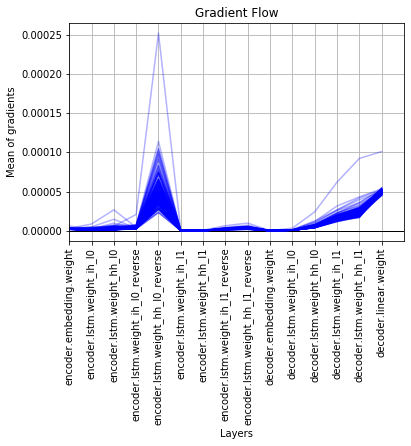

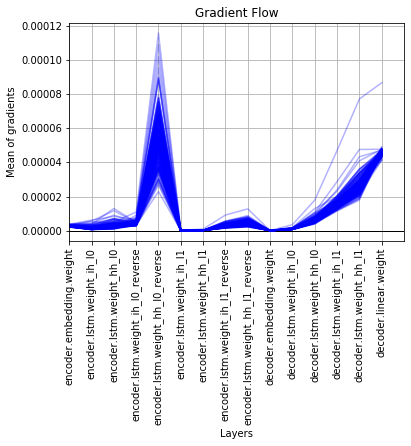

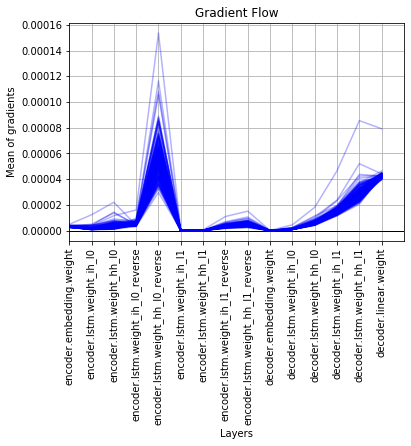

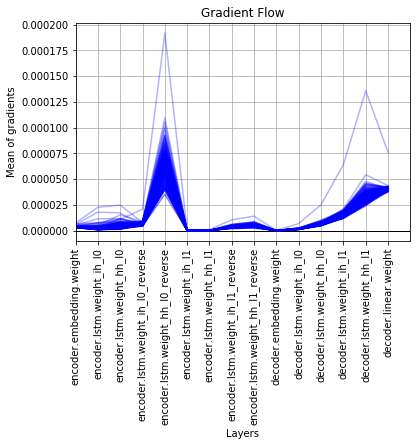

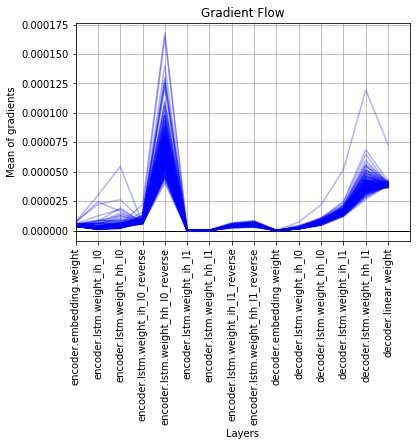

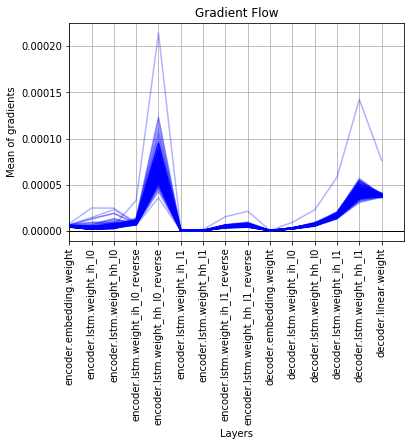

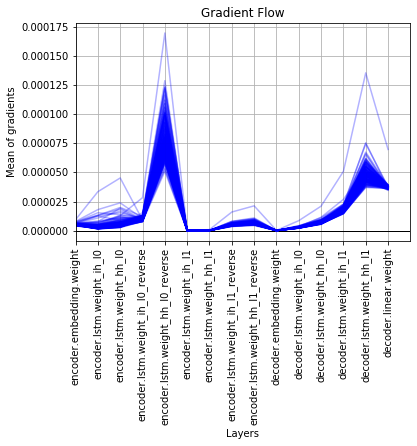

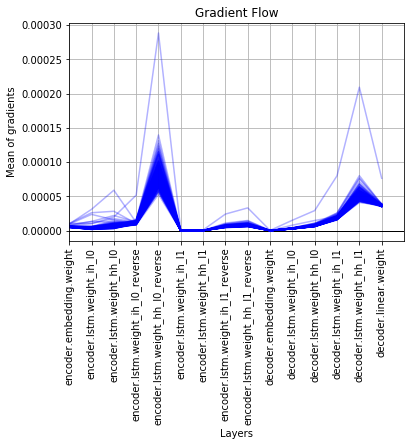

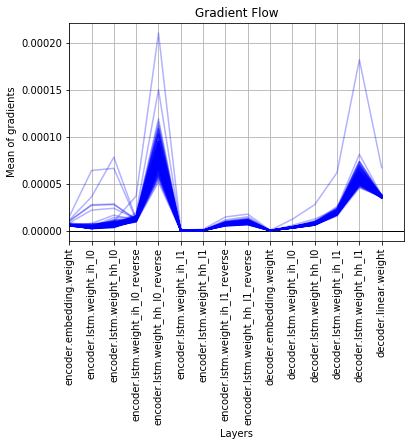

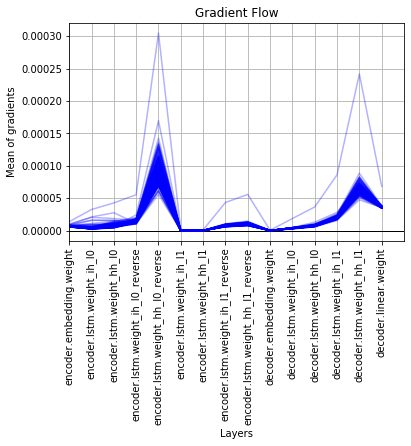

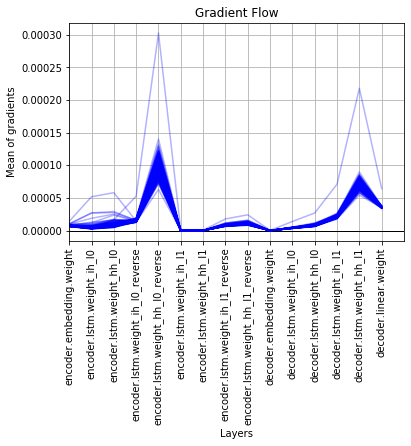

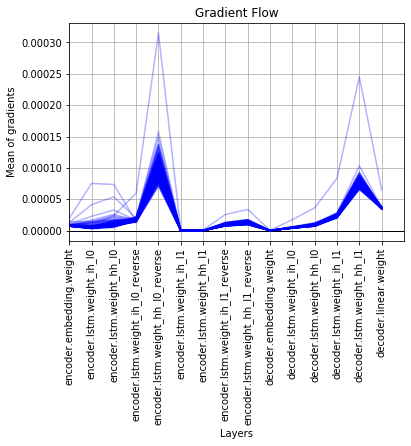

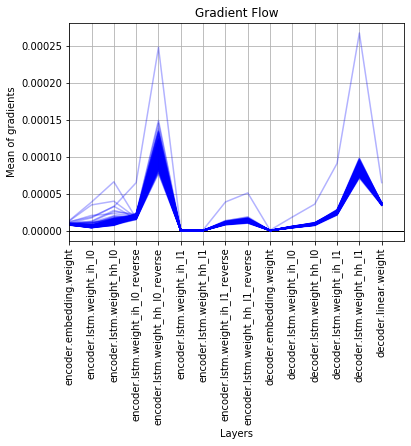

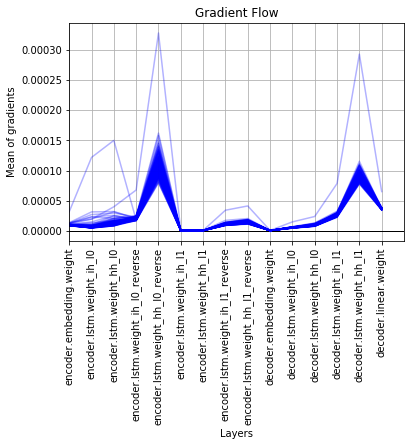

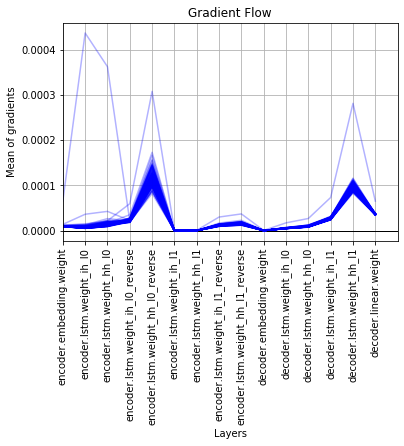

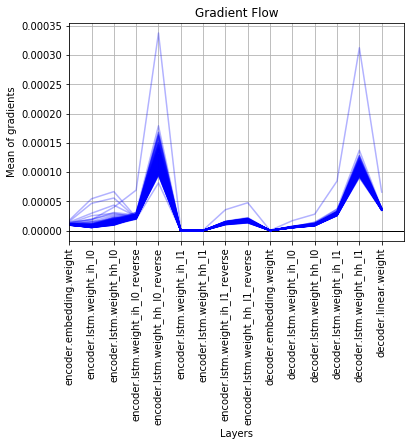

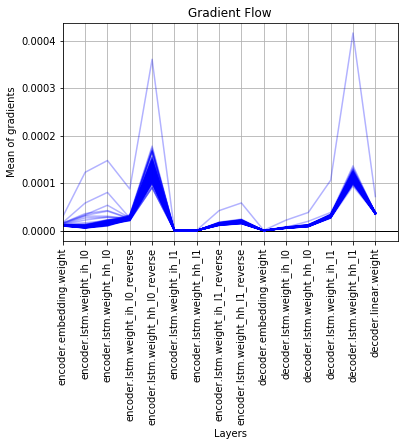

In [62]:
history = train(model, optimizer, criterion, train_iterator, valid_iterator,
                n_epochs=N_EPOCHS, grad_clip=GRAD_CLIP)

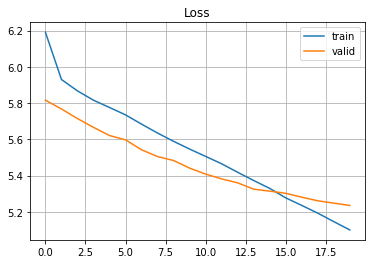

In [63]:
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='valid')
plt.title('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [64]:
# model.load_state_dict(torch.load('./saved_models/seq2seq.pt'))
test_loss = evaluate(model, criterion, test_iterator)
print('Test loss:', test_loss)

Test loss: 5.213905126490491


In [79]:
fr = "Ne vous laissez pas abuser par les apparences."
ex = FR.preprocess(normalize_string(fr))
src = FR.numericalize([ex], DEVICE)

dest = model(src, target_len=20, eos_index=EN.vocab.stoi[EN.eos_token])
for i in dest.argmax(dim=-1).squeeze().tolist():
    print(EN.vocab.itos[i], end=' ')

you you not to <unk> <unk> . . <eos> 